In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
from warnings import filterwarnings
import numpy as np
import nltk
from wordcloud import WordCloud , STOPWORDS
filterwarnings("ignore")

In [2]:
def overview(df , count = True , just_null = False , just_object = False):
    import pandas as pd
    
    print(f"  Number of Rows  = {df.shape[0]:,}")
    print(f"Number of Columns = {df.shape[1]:,}")

    table = pd.DataFrame([])
    table["Missing Percentage"] = (df.isna().sum().to_frame() / df.shape[0] * 100).round(1)
    table["Missing Count"] = df.isna().sum()
    table["Data Type"] = df.dtypes
    table.index.name = "Column"
    
    table = table.sort_values(by = ["Missing Count" , "Data Type"] , ascending = [False , False])
    
    if just_object == True:
        table = table.loc[table["Data Type"] == "object"]
    if just_null == True:
        table = table.loc[table["Missing Count"] > 0] 
    if count == False:
        table = table.drop("Missing Count" , axis = 1)
    else:
        table["Missing Count"] = table["Missing Count"].apply(lambda x: f"{x:,}")
    return table

In [3]:
df = pd.read_csv("train_data.csv" , parse_dates = ["reviewTime"])

## 0. A Very Brief Review and Preprocess

In [4]:
overview(df)

  Number of Rows  = 838,944
Number of Columns = 11


,Missing Percentage,Missing Count,Data Type
Column,,,
vote,77.2,"647,476",object
style,41.5,"348,331",object
reviewerName,0.0,227,object
summary,0.0,76,object
reviewerID,0.0,0,object
asin,0.0,0,object
reviewText,0.0,0,object
reviewTime,0.0,0,datetime64[ns]
overall,0.0,0,int64


In [5]:
df.duplicated().sum()

np.int64(8327)

In [6]:
df["vote"] = df["vote"].str.replace("," , "").fillna(0).astype(float).astype(int)

In [7]:
df["reviewAge"] = df["reviewTime"] - df["reviewTime"].min()
df["reviewAge"] = df["reviewAge"].dt.days.astype(int)
df = df.drop(columns = ["reviewTime"])

In [8]:
df = df.drop(columns = ["style"  , "unixReviewTime" , "verified"])

## 1. `overall` Distribution

### 1.1. As Bar Chart

In [9]:
A = df["overall"].value_counts().sort_index(ascending = True)
B = (A / A.sum()) * 100

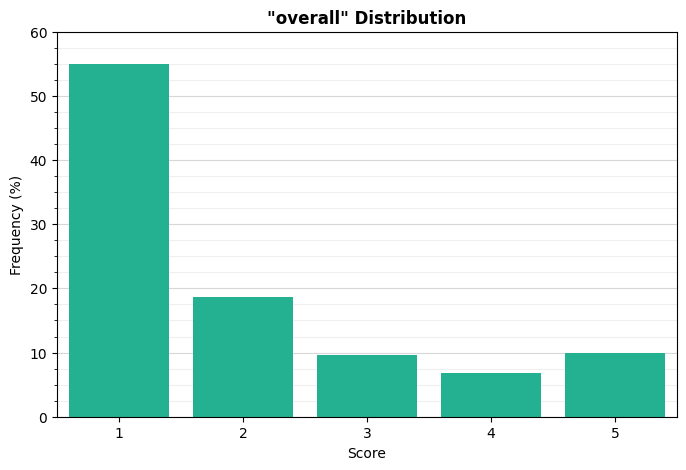

In [33]:
plt.rcParams["figure.dpi"] = 100
fig , ax = plt.subplots(figsize = (8 , 5))
# sbn.barplot(x = B.sort_index(ascending = False).index , y = B.values , color = "indianred" , ax = ax)
sbn.barplot(x = B.sort_index(ascending = False).index , y = B.values ,
            color = "#24b191" , ax = ax , saturation = 1)
ax.set_xlabel("Score")
ax.set_ylabel("Frequency (%)")
ax.set_title("\"overall\" Distribution" , weight = "bold")
ax.set_ylim(0 , 60)
ax.set_axisbelow(True)

ax.yaxis.grid(True, linestyle="-", alpha = 0.5)
ax.yaxis.set_minor_locator(plt.MultipleLocator(2.5))
ax.grid(which = "minor" , linestyle = "-" , alpha = 0.2)

plt.show()

### 1.2. As Table

In [11]:
overall_frequency = (df["overall"].value_counts() / df.shape[0]).to_frame() * 100
overall_frequency = overall_frequency.round(1).sort_index(ascending = False)
overall_frequency.columns = ["Frequnecy (%)"]
overall_frequency.index.name = "Vote"
overall_frequency

,Frequnecy (%)
Vote,
5,55.0
4,18.7
3,9.7
2,6.8
1,9.9


### 1.3. Analysis

<div style="font-family: 'IranSans'; font-size: 16px; text-align: right; direction: rtl;">
داده‌ها نامتوزان هستند (حدود ۵۵ درصد داده‌ها متعلق به کلاس ۵ هستند، این عدد به طور متوسط باید ۲۰ درصد می‌بود.

راه حل این مشکل upsamplig است.
</div>


## 2. World Clouds

### 2.1. Plot

In [12]:
df["sentiment"] = df["overall"].map({5 : "positive" , 4 : "positive" , 3 : "neutral" , 2 : "negative" , 1 : "negative"})

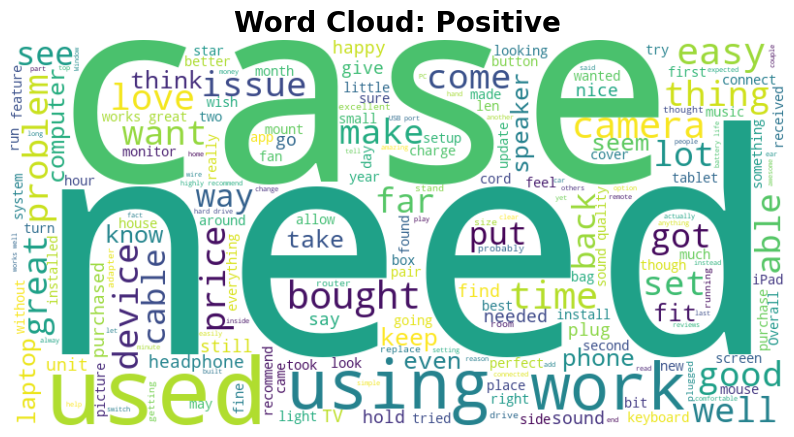

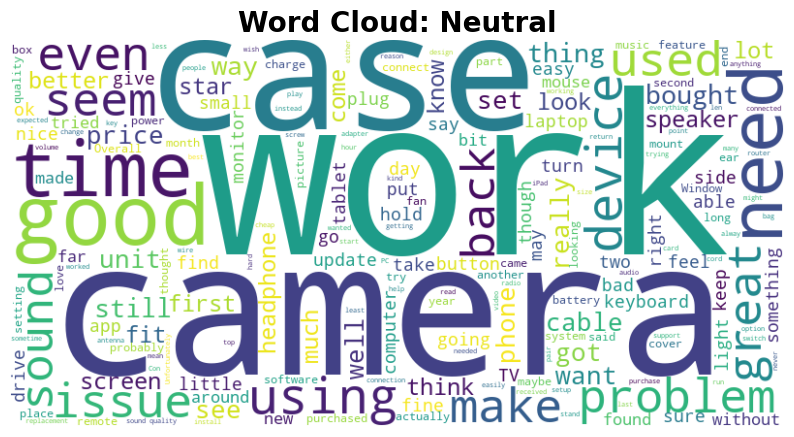

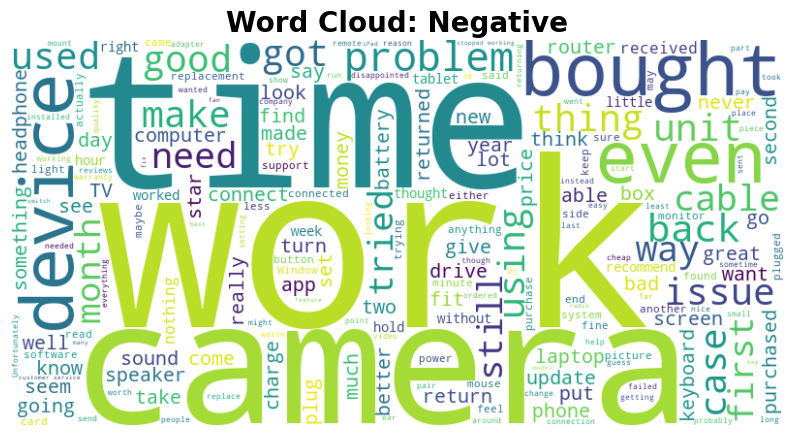

In [13]:
plt.rcParams["figure.dpi"] = 100
stop_words1 = set(STOPWORDS)
stop_words2 = set(nltk.corpus.stopwords.words("english"))
stop_words3 = {"product" , "amazon" , "review" , "item" , "buy" , "use" , "one"}
stop_words = stop_words1.union(stop_words2.union(stop_words3))

for sentiment in ["positive" , "neutral" , "negative"]:
    # ax.axhline(y = ax.get_title().splitlines()[0], color = "black", linestyle = "-", linewidth = 1)
    text = " ".join(df.loc[df["sentiment"] == sentiment , "reviewText"].dropna())
    wc = WordCloud(width = 800 , height = 400 , background_color = "white" , stopwords = stop_words , colormap = "viridis").generate(text)
    fig , ax = plt.subplots(figsize = (10 , 7))
    ax.imshow(wc , interpolation = "bilinear")
    ax.axis("off")
    ax.set_title(f"Word Cloud: {sentiment.capitalize()}" , fontsize = 20 , weight = "bold")
    plt.show()
# df = df.iloc[: , :-1]

### 2.2. Analysis

## 3. Most Helpful Users

In [14]:
most_helpful = df.groupby("reviewerID")["vote"].sum().sort_values(ascending = False).head(10)

most_helpful = pd.merge(
    left = most_helpful,
    right = df[["reviewerID" , "reviewerName"]],
    how = "left",
    on = "reviewerID"
).drop_duplicates()

most_helpful.index = most_helpful["reviewerID"]
most_helpful = most_helpful.drop(columns = ["reviewerID"])
most_helpful = most_helpful[["reviewerName" , "vote"]]
most_helpful.columns = ["Reviewr Name" , "Total Votes"]
most_helpful.index.name = "Reviewer ID"
most_helpful["Total Votes"] = most_helpful["Total Votes"].apply(lambda x: "{:,}".format(int(x)))
most_helpful

,Reviewr Name,Total Votes
Reviewer ID,,
A25GROL6KJV3QG,Benson Leung,"4,345"
A3KJ0DF3LTNJ6X,Voltron00x,"3,096"
A1KPFZCS71QKW5,nycebo,"2,978"
AMYCUX8EWEUVV,Mayra S.,"2,605"
ADLVFFE4VBT8,Cthulhu,"2,605"
A2IK776FY6MEMG,Obi Wan,"2,177"
A1GHPJB2N0D0RL,Chris Upton,"2,167"
AW7UMXXJKFSNS,Sally B.,"1,912"
A2VQ0V1TWXF3U7,Mark A. Baker,"1,820"


## 4. Review Length Distribution

In [15]:
df["review_length"] = df["reviewText"].str.len()

### 4.1. Original

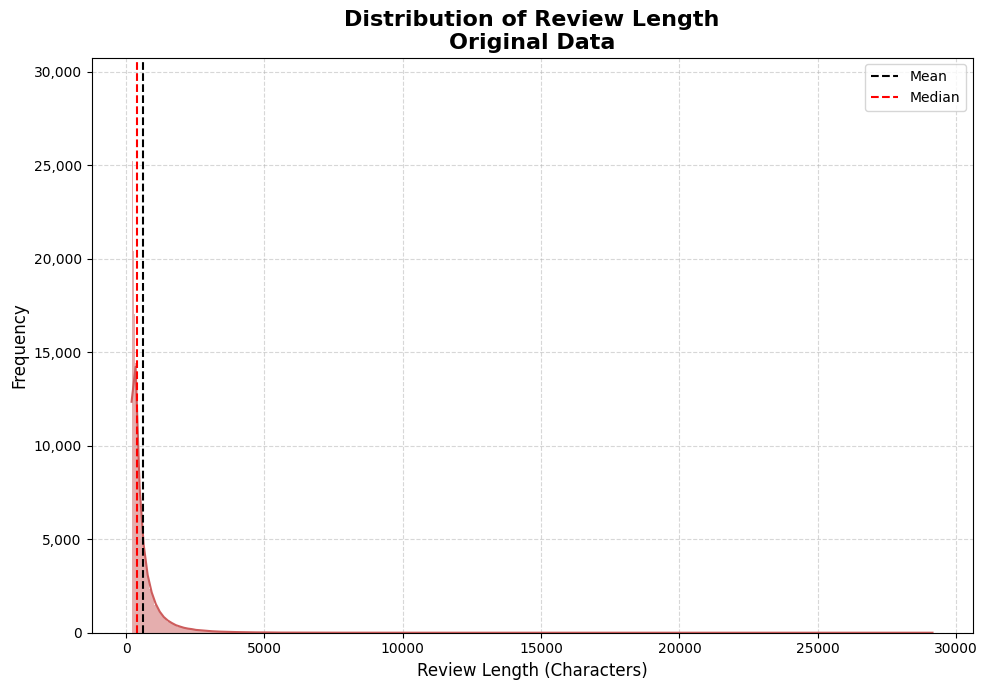

In [16]:
plt.rcParams["figure.dpi"] = 100
data = pd.Series(df["review_length"])
fig , ax = plt.subplots(figsize=(10, 7))
sbn.histplot(data , ax = ax, color = "indianred", kde = True , edgecolor="white" , bins = "auto")
ax.axvline(data.mean() , color='black', linestyle='--', linewidth=1.5 , label = "Mean")
ax.axvline(data.median() , color='red', linestyle='--', linewidth=1.5 , label = "Median")
ax.set_title( "Distribution of Review Length\nOriginal Data" , fontsize=16 , fontweight='bold')
ax.set_xlabel("Review Length (Characters)" , fontsize = 12)
ax.set_ylabel("Frequency", fontsize = 12)
ax.legend()
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x , p: format(int(x) , ",")))
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

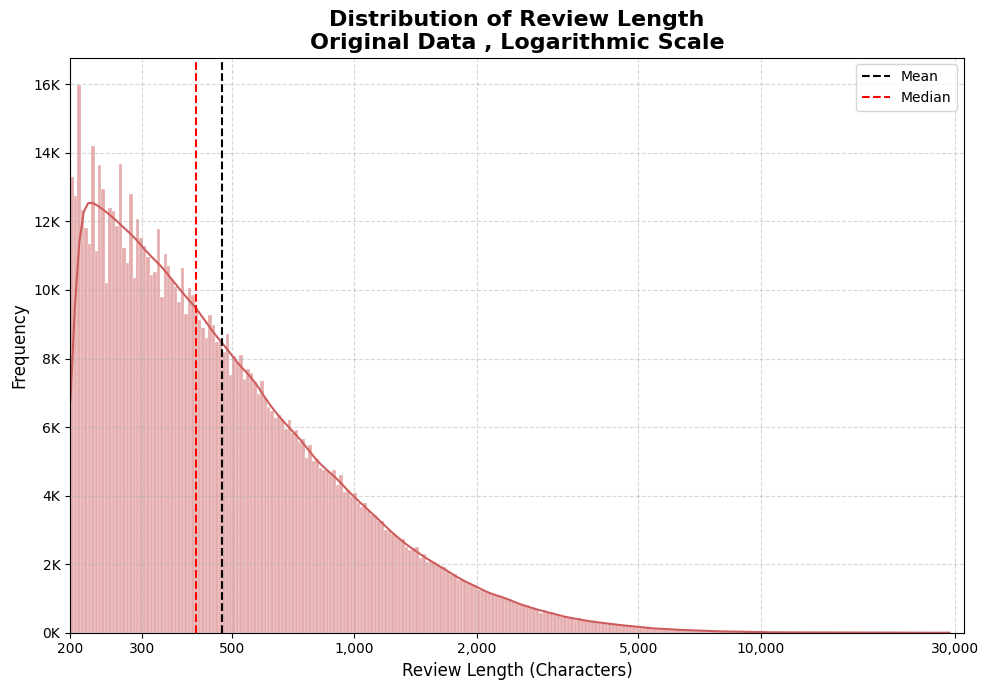

In [17]:
plt.rcParams["figure.dpi"] = 100
data = pd.Series(np.log10(df["review_length"]))
fig , ax = plt.subplots(figsize=(10, 7))
sbn.histplot(data , ax = ax, color = "indianred", kde = True , edgecolor="white" , bins = "auto")
ax.axvline(data.mean() , color='black', linestyle='--', linewidth=1.5 , label = "Mean")
ax.axvline(data.median() , color='red', linestyle='--', linewidth=1.5 , label = "Median")
ax.set_title( "Distribution of Review Length\nOriginal Data , Logarithmic Scale" , fontsize=16 , fontweight='bold')
ax.set_xlabel("Review Length (Characters)", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
ax.set_xlim(2.3 , 4.5)
vals = [200 , 300 , 500 , 1000 , 2000 , 5000 , 10000 , 30000]
ax.set_xticks(np.log10(vals))
ax.set_xticklabels([f"{v:,}" for v in vals])
ax.set_yticklabels([f"{int(y/1000)}K" for y in ax.get_yticks()])
ax.grid(True , linestyle = '--', alpha = 0.5)
ax.legend()
plt.tight_layout()

In [18]:
m = df["review_length"].median()

In [19]:
print(f"Review length median = {m :.0f}")

Review length median = 408


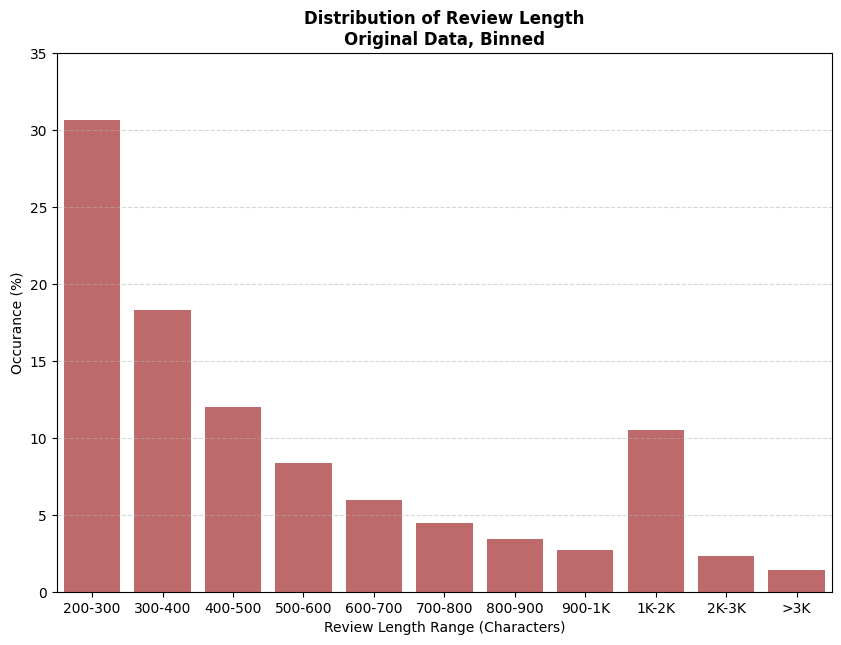

In [20]:
fig , ax = plt.subplots(figsize = (10 , 7))
total = len(df)
bins = [200 , 300 , 400 , 500 , 600 , 700 , 800 , 900 , 1000 , 2000 , 3000 , df["review_length"].max()]
labels = ["200-300" , "300-400" , "400-500" , "500-600" ,
          "600-700" , "700-800" , "800-900" , "900-1K" ,
          "1K-2K" ,"2K-3K" , ">3K"]
df["len_bin"] = pd.cut(df["review_length"] , bins = bins , labels = labels , include_lowest = True)

sbn.countplot(x = "len_bin" , data = df , color = "indianred" , ax = ax)
ax.set_xlabel("Review Length Range (Characters)")
ax.set_ylabel("Occurance (%)")
ax.set_title("Distribution of Review Length\nOriginal Data, Binned" , weight = "bold")
ax.set_ylim(0 , 0.3)
ax.set_yticks(np.arange(0 , 0.36 , 0.05))
ax.set_yticklabels([f"{int(y*100):,}" for y in np.arange(0 , 0.36 , 0.05)])
ax.yaxis.grid(True, linestyle="--", alpha=0.5)
for p in ax.patches:
    p.set_height(p.get_height()/total)
plt.show()
df = df.iloc[: , :-1]

### 4.2. Get Did of Some Outliers 

In [21]:
for outlier_boundary in [1_000 , 2_000 , 3_000 , 4_000 , 5_000 , 10_000 , 20_000 , 30_000]:
    outlier_ratio = (df["review_length"] > outlier_boundary).sum() / df.shape[0]
    print(f"{outlier_ratio * 100:.3f}% of reviews exceed {outlier_boundary :,} characters in length.")

14.150% of reviews exceed 1,000 characters in length.
3.672% of reviews exceed 2,000 characters in length.
1.384% of reviews exceed 3,000 characters in length.
0.642% of reviews exceed 4,000 characters in length.
0.327% of reviews exceed 5,000 characters in length.
0.031% of reviews exceed 10,000 characters in length.
0.002% of reviews exceed 20,000 characters in length.
0.000% of reviews exceed 30,000 characters in length.


In [22]:
outlier_boundary = 2_000
df_filtered = df.loc[df["review_length"] <= outlier_boundary]

### 4.3. Review Length Distribution (without Outliers)

minimum = 200
median  = 396
maximum = 2,000
mean    = 526
std     = 357.4


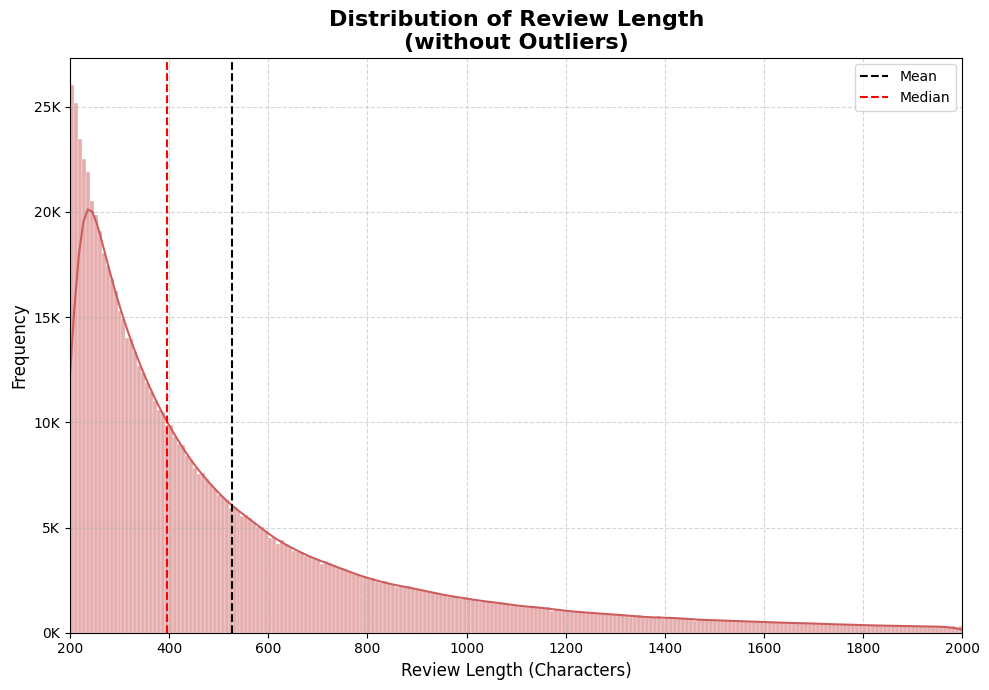

In [23]:
data = pd.Series(df_filtered["review_length"])
print(f"minimum = {data.min()}")
print(f"median  = {int(data.median())}")
print(f"maximum = {data.max():,}")
print(f"mean    = {int(data.mean())}")
print(f"std     = {data.std():.1f}")
fig , ax = plt.subplots(figsize=(10, 7))
sbn.histplot(data , ax = ax, color = "indianred", kde = True , edgecolor="white" , bins = "auto")
ax.axvline(data.mean() , color='black', linestyle='--', linewidth=1.5 , label = "Mean")
ax.axvline(data.median() , color='red', linestyle='--', linewidth=1.5 , label = "Median")
ax.set_title( "Distribution of Review Length\n(without Outliers)" , fontsize=16 , fontweight='bold')
ax.set_xlabel("Review Length (Characters)", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
ax.set_xlim(200 , outlier_boundary)
ax.set_yticklabels([f"{int(y/1000)}K" for y in ax.get_yticks()])
ax.grid(True , linestyle = '--', alpha = 0.5)
ax.legend()
plt.tight_layout()

## 5. Most Popular Products

In [24]:
popular_products = df.loc[df["overall"] == 5 , "asin"].value_counts().sort_values(ascending = False).head(10).to_frame()
asin2info = pd.read_csv("title_brand.csv" , index_col = 0)

In [25]:
popular_products = pd.merge(
    left = popular_products,
    right = asin2info,
    on = "asin",
    how = "left"
)
popular_products = popular_products[["count" , "brand" , "title"]]
popular_products.columns = ["5Star Votes" , "Brand" , "Product Title"]

In [26]:
pd.set_option("display.max_colwidth", 1000)
popular_products

,5Star Votes,Brand,Product Title
asin,,,
B010OYASRG,1163,Cambridge Soundworks,"OontZ Angle 3 Enhanced Stereo Edition IPX5 Splashproof Portable Bluetooth Speaker with Volume Booster AMP 10 Watts Power, Custom Bass Radiator, 100' Wireless Range Bluetooth 4.2"
B00L0YLRUW,659,NETGEAR,NETGEAR N300 WiFi Range Extender (EX2700)
B01DA0YCNC,600,Roku,Roku Streaming Stick (3600R) - HD Streaming Player with Quad-Core Processor
B000VS4HDM,598,StarTech,StarTech USB 2.0 to SATA IDE Adapter (USB2SATAIDE)
B0043T7FXE,552,Logitech,"Logitech M570 Wireless Trackball Mouse &ndash; Ergonomic Design with Sculpted Right-hand Shape, Compatible with Apple Mac and Microsoft Windows Computers, USB Unifying Receiver, Dark Gray"
B00OBRE5UE,529,Samsung,Samsung 850 EVO 500GB 2.5-Inch SATA III Internal SSD (MZ-75E500B/AM)
B00S9SGNNS,471,Asus,"ASUS Tri-Band Gigabit (AC3200) WiFi Router (Up to 3167 Mbps) with MU-MIMO to ensure Lag-Free Gaming, AiProtection network security powered by Trend Micro, Adaptive QoS and Parental Control (RT-AC3200)"
B000WYVBR0,448,VideoSecu,"VideoSecu ML531BE TV Wall Mount for Most 27&quot;-55&quot; LED LCD Plasma Flat Screen Monitor up to 88 lb VESA 400x400 with Full Motion Swivel Articulating 20 in Extension Arm, HDMI Cable &amp; Bubble Level WP5"
B00P7EVST6,433,"Arlo Technologies, Inc",Arlo - Wireless Home Security Camera System | Indoor/Outdoor | 2 camera kit (Discontinued)


## 6. Brands with Most Reviews

In [27]:
popular_brands = pd.merge(
    left = df[["asin" , "reviewText"]],
    right = asin2info,
    on = "asin",
    how = "left"
)
popular_brands = popular_brands.groupby("asin")["reviewText"].count().sort_values(ascending = False)
popular_brands = popular_brands.head(10).to_frame()
popular_brands = pd.merge(
    left = popular_brands,
    right = asin2info[["brand"]],
    how = "left",
    on = "asin"
)
popular_brands["avg"] = popular_brands.index.map(lambda x: df.loc[df["asin"] == x, "overall"].mean()).round(2)

In [28]:
popular_brands = popular_brands.sort_values(by = ["avg"] , ascending =[False])
popular_brands = popular_brands[["brand" , "reviewText" , "avg"]]
popular_brands.columns = ["Brand Name" , "# of Reviews" , "Average Score"]
popular_brands

,Brand Name,# of Reviews,Average Score
asin,,,
B000VS4HDM,StarTech,793,4.40
B0043T7FXE,Logitech,856,4.29
B010OYASRG,Cambridge Soundworks,1853,4.25
B01DA0YCNC,Roku,996,4.08
B00JX1ZS5O,Sabrent,760,4.01
B00L0YLRUW,NETGEAR,1205,3.88
B0001FTVEK,Sennheiser,748,3.84
B0001FTVEK,Sennheiser,748,3.84
B00BUSDVBQ,TP-LINK,764,3.73


## 7. Check Possible Corrolations

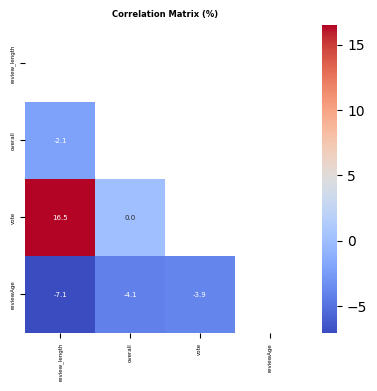

In [32]:
df2 = df[["review_length" , "overall" , "vote" , "reviewAge"]]
corr = df2.corr() * 100
mask = np.triu(np.ones_like(corr, dtype=bool)) # to avoid repetition
fig , ax = plt.subplots(1,1)
fig.set_size_inches(4.5 , 4)
sbn.heatmap(corr,
            ax = ax,
            mask = mask,
            cmap='coolwarm',
            annot = True,
            annot_kws = {"size": 5},
            fmt = ".1f",
            yticklabels = df2.columns,
            xticklabels = df2.columns)
ax.set_title("Correlation Matrix (%)" , fontsize = 6 , fontweight = "bold")
ax.tick_params(axis = 'x' , labelsize = 4)
ax.tick_params(axis = 'y' , labelsize = 4)
plt.show()

In [30]:
from scipy.stats import spearmanr
test_name = "Spearman's Rank-Order Correlation"

null_hypothesis = "H0: There is no monotonic relationship between review_length and vote."
alternative_hypothesis = "H1: There is a monotonic relationship between review_length and vote."
alpha = 0.05
spearman_corr, p_value = spearmanr(df["review_length"], df["vote"])

print(f"Test Name: {test_name}")
print(70 * "-")
print(f"{null_hypothesis}")
print(f"{alternative_hypothesis}")
print(70 * "-")
print(f"Spearman correlation coefficient = {spearman_corr:.4f}")
print(f"P-value = {p_value * 100 :.2f} %")

if p_value < alpha:
    print("Test Result: Reject the null hypothesis. There IS a significant monotonic relationship.")
else:
    print("Test Result: Fail to reject the null hypothesis. NO significant monotonic relationship detected.")

Test Name: Spearman's Rank-Order Correlation
----------------------------------------------------------------------
H0: There is no monotonic relationship between review_length and vote.
H1: There is a monotonic relationship between review_length and vote.
----------------------------------------------------------------------
Spearman correlation coefficient = 0.2046
P-value = 0.00 %
Test Result: Reject the null hypothesis. There IS a significant monotonic relationship.


In [31]:
null_hypothesis = "H0: There is no monotonic relationship between review_length and reviewAge."
alternative_hypothesis = "H1: There is a monotonic relationship between review_length and reviewAge."
spearman_corr, p_value = spearmanr(df["review_length"], df["reviewAge"])

print(f"Test Name: {test_name}")
print(70 * "-")
print(f"{null_hypothesis}")
print(f"{alternative_hypothesis}")
print(70 * "-")
print(f"Spearman correlation coefficient = {spearman_corr:.4f}")
print(f"P-value = {p_value * 100 :.2f} %")

if p_value < alpha:
    print("Test Result: Reject the null hypothesis. There IS a significant monotonic relationship.")
else:
    print("Test Result: Fail to reject the null hypothesis. NO significant monotonic relationship detected.")

Test Name: Spearman's Rank-Order Correlation
----------------------------------------------------------------------
H0: There is no monotonic relationship between review_length and reviewAge.
H1: There is a monotonic relationship between review_length and reviewAge.
----------------------------------------------------------------------
Spearman correlation coefficient = -0.0705
P-value = 0.00 %
Test Result: Reject the null hypothesis. There IS a significant monotonic relationship.
